Just playing around [this paper](https://arxiv.org/pdf/2310.11453.pdf). Trying to understand how BitLinear layer works. 

In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
torch.__version__

'2.2.1+cu121'

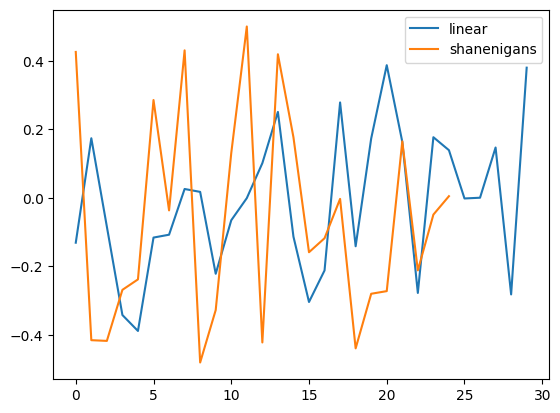

In [305]:
plt.plot(torch.nn.Linear(5, 6).weight.data.view(-1))
plt.plot(((2*torch.rand((5,5)) - 1)/2).view(-1))
plt.legend(["linear", "shanenigans"])

In [230]:
wei = torch.rand((5,5))
wei = (2 * wei - 1)/2 # move range from [0,1] -> [-1, 1]
s = torch.sign(wei)

s = s.to(torch.int8) # quantized as int8 afterwards, however dequantized one is being used.
wei, s
# s.dtype

(tensor([[-0.0703,  0.0924,  0.0655, -0.2999,  0.1318],
         [-0.4207,  0.2686,  0.0239,  0.1819, -0.1394],
         [-0.3540,  0.2451,  0.1808,  0.0952,  0.0838],
         [-0.2485,  0.0839, -0.4098,  0.0842, -0.1750],
         [-0.2864,  0.3584,  0.3312,  0.4524, -0.3319]]),
 tensor([[-1,  1,  1, -1,  1],
         [-1,  1,  1,  1, -1],
         [-1,  1,  1,  1,  1],
         [-1,  1, -1,  1, -1],
         [-1,  1,  1,  1, -1]], dtype=torch.int8))

In [259]:
def convert_type(toChar=False):
    def decorator(func):
        def wrapper(s, *args, **kwargs):
            s = s.to(torch.int8 if toChar else torch.bfloat16)  # per the paper, bfloat16 is used why is it so? 
            return func(s, *args, **kwargs)
        return wrapper
    return decorator

"""
Takes the standard deviation"-ish" (s) as a parameter to normalize
"""
@convert_type()
def dequantize(s):
    # s = s.to(torch.float64)
    alpha = s.mean()
    print(alpha.dtype)
    s *= alpha
   
    return s

dequantize((2*torch.rand((5,5))-1)/2)

torch.bfloat16


tensor([[ 0.0253, -0.0195,  0.0164, -0.0084, -0.0281],
        [-0.0148,  0.0041,  0.0095,  0.0215,  0.0269],
        [ 0.0001,  0.0292,  0.0032, -0.0256, -0.0084],
        [ 0.0187, -0.0320,  0.0064,  0.0067,  0.0112],
        [ 0.0312,  0.0124,  0.0219,  0.0137, -0.0081]], dtype=torch.bfloat16)

In [260]:
"""
Binarize using STE, simply bypassing the binarization in the backward pass
std - group mean
"""
@convert_type()
def binarize(v, std):
    v -= std
    v = torch.sign(v)
    alpha = v.mean()
    return (v - alpha).detach() + alpha 

binarize((2*torch.rand((5,5))-1)/2, 0)

tensor([[ 0.9961, -1.0000, -1.0000, -1.0000,  0.9961],
        [-1.0000,  0.9961, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.9961, -1.0000, -1.0000, -1.0000],
        [-1.0000,  0.9961, -1.0000,  0.9961, -1.0000]], dtype=torch.bfloat16)

tensor(-0.0053) tensor(0.2858)


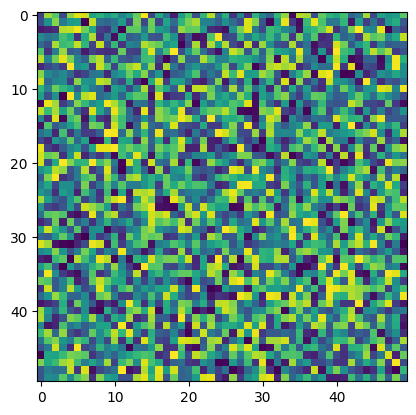

torch.bfloat16


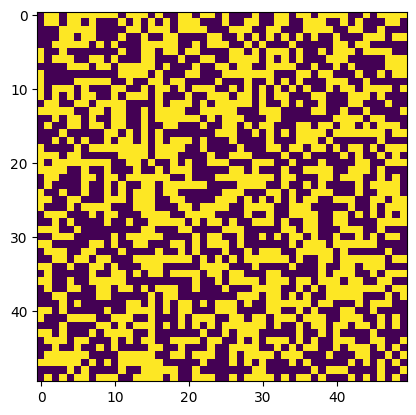

In [261]:
"""
normalizing the weight groupwise,
"""
num_groups = 10
wei = torch.rand((50,50))
wei = (2 * wei - 1)/2 # move range from [0,1] -> [-1, 1]
print(wei.mean(), wei.std())
plt.imshow(wei)
plt.show()

s = torch.sign(wei)
s = dequantize(s)

group_batch_size = wei.shape[0] // num_groups
new_wei = torch.zeros_like(wei)



for group in range(num_groups):
    start, end = group * group_batch_size, group_batch_size * (group+1)
    group_wei = wei[start:end]
    alpha = group_wei.mean()
    group_wei = binarize(group_wei, alpha)
    new_wei[start:end] = group_wei

new_wei
plt.imshow(new_wei)
plt.show()

tensor(-0.0044) tensor(0.2037)


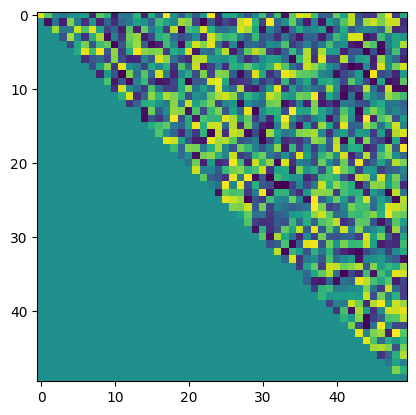

torch.bfloat16
tensor(-0.2792) tensor(0.9601)


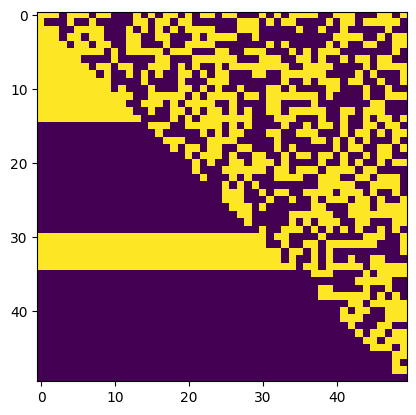

In [270]:
"""
Trying the same thing out with masked fill attached
"""
"""
normalizing the weight groupwise,
"""
num_groups = 10
wei = torch.rand((50,50))
wei = (2 * wei - 1)/2 # move range from [0,1] -> [-1, 1]
wei = torch.triu(wei)
print(wei.mean(), wei.std())
plt.imshow(wei)
plt.show()

s = torch.sign(wei)
s = dequantize(s) # why????

group_batch_size = wei.shape[0] // num_groups
new_wei = torch.zeros_like(wei)

for group in range(num_groups):
    start, end = group * group_batch_size, group_batch_size * (group+1)
    group_wei = wei[start:end]
    alpha = group_wei.mean()
    group_wei = binarize(group_wei, alpha)
    new_wei[start:end] = group_wei

print(new_wei.mean(), new_wei.std())
plt.imshow(new_wei)
plt.show()

 - [ ] How is this even possible??
 - [ ] How does it even work on transformer achitecture since mashed attention breaks the weight initilialization??
 - [ ] What's STE??

### Observations
- Impefections significantly reduce when using bfloat16, why??


tensor(-0.0068) tensor(0.2890)


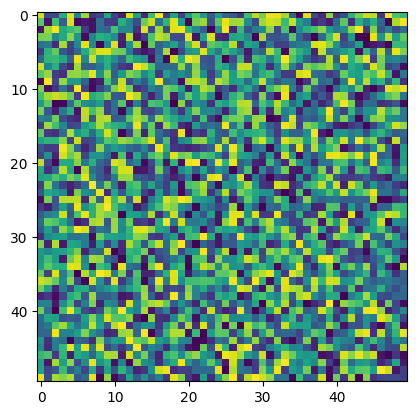

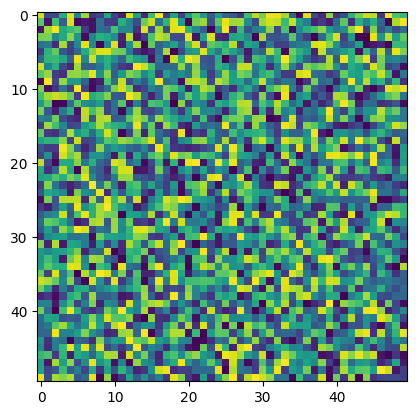

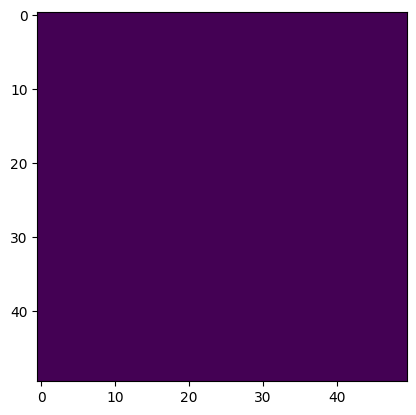

In [298]:
"""
quantization of activations groupwise
"""
num_groups = 10
Q_b = 2 ** 7 # taking that it is 8 bit

wei = torch.rand((50,50))
wei = (2 * wei - 1)/2 # move range from [0,1] -> [-1, 1], taking thes to be the activations
wei.to(torch.int8)
print(wei.mean(), wei.std())
# wei = F.normalize(wei)
# print(wei.mean(), wei.std())
plt.imshow(wei)
plt.show()

s = torch.sign(wei)

group_batch_size = wei.shape[0] // num_groups
new_wei = torch.zeros_like(wei)



for group in range(num_groups):
    start, end = group * group_batch_size, group_batch_size * (group+1)
    group_wei = wei[start:end]
    alpha = group_wei.abs().max()
    group_wei = torch.clamp(
        group_wei * Q_b / alpha,
        -group_wei,
        group_wei,
    )
    new_wei[start:end] = group_wei
plt.imshow(new_wei)
plt.show()
plt.imshow(new_wei - wei)
plt.show()

Unlike quantizing the weights, this gives a far better resonable results, overall better accuracy 

## Conclusion
I am not a fan of `dequantize()` weight dequantization is implemented. There are a lot of gotchas. Especially in the attention block. 
I Will check more on that. I might be wrong.

In [38]:
x = torch.rand((10, 5,3)) # B, T -> one-hot encoding -> B, T, C 
x.chunk(2, dim=1), x.chunk(2, dim=0), 

((tensor([[[0.2925, 0.5499, 0.6509],
           [0.6671, 0.0486, 0.9536],
           [0.9179, 0.7505, 0.3022]],
  
          [[0.5390, 0.5268, 0.9698],
           [0.8160, 0.6999, 0.4057],
           [0.9797, 0.4631, 0.1455]],
  
          [[0.6498, 0.6843, 0.1338],
           [0.9312, 0.0563, 0.4799],
           [0.0809, 0.8487, 0.3524]],
  
          [[0.9009, 0.1644, 0.3618],
           [0.7408, 0.8735, 0.1099],
           [0.2540, 0.7677, 0.7000]],
  
          [[0.6389, 0.3745, 0.7664],
           [0.5371, 0.3907, 0.2515],
           [0.9764, 0.5104, 0.1589]],
  
          [[0.5228, 0.8571, 0.6824],
           [0.4986, 0.3515, 0.8020],
           [0.4216, 0.4570, 0.5617]],
  
          [[0.9860, 0.3542, 0.1745],
           [0.0310, 0.1001, 0.6890],
           [0.6842, 0.4433, 0.3631]],
  
          [[0.7609, 0.6723, 0.0469],
           [0.5399, 0.2388, 0.5351],
           [0.2795, 0.3323, 0.7699]],
  
          [[0.9922, 0.7068, 0.3551],
           [0.3154, 0.0966, 0.8420],
      

In [99]:
ln = torch.nn.LayerNorm(3)
z = torch.stack(list(ln(batch) for batch in x.chunk(5, dim=0)), dim=0)
z.shape  

torch.Size([5, 2, 5, 3])

In [100]:
gamma = torch.max(z, dim=0)
gamma.values.shape

torch.Size([2, 5, 3])

In [103]:
gamma = torch.max(x)
gamma
# gamma.values.shape, x.shape

tensor(0.9954)

# Testing mine vs original implemntation

In [2]:
import transformers.models as m 

config = m.bert.BertConfig(vocab_size=1000, max_position_embeddings=10)

model = m.bert.BertForTokenClassification(config)

# model = inject(model, [(nn.Linear, BitLinear), (nn.LayerNorm, RMSNorm)])
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(1000, 768, padding_idx=0)
      (position_embeddings): Embedding(10, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem